In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import sys
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

time: 9.22 s (started: 2022-02-16 06:50:43 -08:00)


In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




time: 179 ms (started: 2022-02-16 06:50:52 -08:00)


In [3]:
sys.path.append('../../')
from src.utils import sample_models_across_time, load_models, hyperparameter_utils, configuration
config = configuration.Config()

time: 121 ms (started: 2022-02-16 06:50:52 -08:00)


In [4]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

time: 4.52 ms (started: 2022-02-16 06:50:52 -08:00)


# Load Scores and move to R

In [7]:
import imp
imp.reload(sample_models_across_time)
imp.reload(load_models)
imp.reload(hyperparameter_utils)
config = configuration.Config()
config.childes_model_args

[['all', 'all'], ['age', 'young'], ['age', 'old'], ['switchboard', 'all']]

time: 8.84 ms (started: 2022-02-16 06:55:03 -08:00)


In [8]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

time: 2.47 s (started: 2022-02-16 06:55:04 -08:00)


In [9]:
np.unique(levdist_scores_across_time.split)

array(['age', 'all', 'switchboard'], dtype=object)

time: 659 ms (started: 2022-02-16 06:55:12 -08:00)


In [10]:
levdist_scores_across_time.loc[levdist_scores_across_time.split == 'switchboard', 'model'] = [
    x.replace('CHILDES', 'Switchboard') for x in  levdist_scores_across_time.loc[levdist_scores_across_time.split \
== 'switchboard'].model]

time: 669 ms (started: 2022-02-16 06:55:14 -08:00)


In [11]:
np.unique(levdist_scores_across_time.model)

array(['Adult BERT without tags, , +-20 utts context',
       'Adult BERT without tags, , same utt only',
       'CHILDES BERT with tags, , +-20 utts context',
       'CHILDES BERT with tags, , same utt only',
       'CHILDES BERT with tags, older children, +-20 utts context',
       'CHILDES BERT with tags, older children, same utt only',
       'CHILDES BERT with tags, younger children, +-20 utts context',
       'CHILDES BERT with tags, younger children, same utt only',
       'CHILDES BERT without tags, , +-20 utts context',
       'CHILDES BERT without tags, , same utt only',
       'CHILDES BERT without tags, older children, +-20 utts context',
       'CHILDES BERT without tags, older children, same utt only',
       'CHILDES BERT without tags, younger children, +-20 utts context',
       'CHILDES BERT without tags, younger children, same utt only',
       'CHILDES Unigram', 'Flat Unigram',
       'Switchboard BERT without tags, , +-20 utts context',
       'Switchboard BERT with

time: 600 ms (started: 2022-02-16 06:55:16 -08:00)


In [12]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

time: 2.33 s (started: 2022-02-16 06:55:17 -08:00)


In [14]:
wfst_scores_across_time.loc[wfst_scores_across_time.split == 'switchboard', 'model'] = [
    x.replace('CHILDES', 'Switchboard') for x in  wfst_scores_across_time.loc[wfst_scores_across_time.split \
== 'switchboard'].model]

time: 248 ms (started: 2022-02-16 06:55:27 -08:00)


In [15]:
np.unique(wfst_scores_across_time.model)

array(['Adult BERT without tags, , +-20 utts context',
       'Adult BERT without tags, , same utt only',
       'CHILDES BERT with tags, , +-20 utts context',
       'CHILDES BERT with tags, , same utt only',
       'CHILDES BERT with tags, older children, +-20 utts context',
       'CHILDES BERT with tags, older children, same utt only',
       'CHILDES BERT with tags, younger children, +-20 utts context',
       'CHILDES BERT with tags, younger children, same utt only',
       'CHILDES BERT without tags, , +-20 utts context',
       'CHILDES BERT without tags, , same utt only',
       'CHILDES BERT without tags, older children, +-20 utts context',
       'CHILDES BERT without tags, older children, same utt only',
       'CHILDES BERT without tags, younger children, +-20 utts context',
       'CHILDES BERT without tags, younger children, same utt only',
       'CHILDES Unigram', 'Flat Unigram',
       'Switchboard BERT without tags, , +-20 utts context',
       'Switchboard BERT with

time: 589 ms (started: 2022-02-16 06:55:28 -08:00)


In [16]:
wfst_scores_across_time.iloc[0]

prior_rank                                                              NaN
prior_prob                                                              NaN
entropy                                                             7.96437
num_tokens_in_context                                                     3
bert_token_id                                                        246234
set                                                                 failure
mask_position                                                           NaN
token                                                                   NaN
utterance_id                                                            NaN
posterior_entropy                                                   3.11747
posterior_rank                                                          NaN
prior_entropy                                                       5.52048
position_in_mask                                                        NaN
kl_flat_to_p

time: 6.54 ms (started: 2022-02-16 06:55:28 -08:00)


In [17]:
raw_scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

time: 1.09 s (started: 2022-02-16 06:55:28 -08:00)


In [18]:
all_args = load_models.gen_all_model_args()

beta_set = {}
lambda_set = {}
for arg_set in all_args:
    
    model_title = load_models.gen_model_title(*arg_set)
    
    this_beta = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'beta')
    this_lambda = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'lambda')

    # correct the model name, but only after loading the hyperparameter file
    if arg_set[0] == 'switchboard':
        corrected_model_title = model_title.replace('CHILDES','Switchboard')
    else:
        corrected_model_title = model_title
        
    
    beta_set[corrected_model_title] = round(this_beta, 3)
    lambda_set[corrected_model_title] = round(this_lambda, 3)
    
pprint(beta_set)
pprint(lambda_set)

{'Adult BERT without tags, , +-20 utts context': 3.5,
 'Adult BERT without tags, , same utt only': 4.2,
 'CHILDES BERT with tags, , +-20 utts context': 3.2,
 'CHILDES BERT with tags, , same utt only': 3.2,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.5,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.2,
 'CHILDES BERT without tags, , same utt only': 3.3,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.5,
 'CHILDES BERT without tags, older children, same utt only': 3.6,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.2,
 'CHILDES BERT without tags, younger children, same utt only': 3.2,
 'CHILDES unigram without tags, , same utt only': 3.5,
 'Flat prior without tags, , same utt only': 3.7,
 'Switchboard BERT without tags, , +-20 u

In [19]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}

tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


time: 345 ms (started: 2022-02-16 06:55:30 -08:00)


In [20]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

time: 2min 23s (started: 2022-02-16 06:55:30 -08:00)


In [21]:
%%R
levels(factor(scores_across_time_short$model))

 [1] "Adult BERT without tags, , +-20 utts context"                  
 [2] "Adult BERT without tags, , same utt only"                      
 [3] "CHILDES BERT with tags, , +-20 utts context"                   
 [4] "CHILDES BERT with tags, , same utt only"                       
 [5] "CHILDES BERT with tags, older children, +-20 utts context"     
 [6] "CHILDES BERT with tags, older children, same utt only"         
 [7] "CHILDES BERT with tags, younger children, +-20 utts context"   
 [8] "CHILDES BERT with tags, younger children, same utt only"       
 [9] "CHILDES BERT without tags, , +-20 utts context"                
[10] "CHILDES BERT without tags, , same utt only"                    
[11] "CHILDES BERT without tags, older children, +-20 utts context"  
[12] "CHILDES BERT without tags, older children, same utt only"      
[13] "CHILDES BERT without tags, younger children, +-20 utts context"
[14] "CHILDES BERT without tags, younger children, same utt only"    
[15] "CHILDES Unigra

In [22]:
%%R
# rename the models

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram",
                 "Switchboard BERT without tags, , +-20 utts context",
                 "Switchboard BERT without tags, , same utt only"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior",
                     "Switchboard BERT without tags, , +-20 utts context" = "Switchboard+Context",
                     "Switchboard BERT without tags, , same utt only" = "Switchboard+OneUtt"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)
successes_across_time = subset(scores_across_time_short, set == 'success')

time: 54.9 s (started: 2022-02-16 06:57:53 -08:00)


In [23]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

time: 9.31 ms (started: 2022-02-16 06:58:48 -08:00)


In [24]:
%%R
overview_set = c(
    'CDL+Context+Tags',
    'BERT+Context',
    'CDL+OneUtt+Tags',
    'BERT+OneUtt',
    'Switchboard+Context',
    'Switchboard+OneUtt',
    'CHILDES 1gram',
    'UniformPrior'
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

time: 16.3 ms (started: 2022-02-16 06:58:48 -08:00)


# Verify Sample Size

In [25]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(successes_and_failures_per_time$bert_token_id))

       set age bert_token_id
1  failure 1.0          1521
2  success 1.0          2412
3  failure 1.5          1890
4  success 1.5          5499
5  failure 2.0          1412
6  success 2.0         10877
7  failure 2.5          1149
8  success 2.5         13980
9  failure 3.0           699
10 success 3.0          8517
11 failure 3.5            85
12 success 3.5          2708
[1] 50749
time: 310 ms (started: 2022-02-16 06:58:48 -08:00)


# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [26]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 1583860  243216
time: 1.12 s (started: 2022-02-16 06:58:48 -08:00)


In [27]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "Switchboard+OneUtt"       "Switchboard+Context"     
[17] "UniformPrior"             "CHILDES 1gram"           
time: 130 ms (started: 2022-02-16 06:58:49 -08:00)


## Levenshtein Distance

In [28]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(scores_across_time_short, auc_by_model)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 1min 16s (started: 2022-02-16 06:58:50 -08:00)


In [29]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 14.7 s (started: 2022-02-16 07:00:06 -08:00)


In [30]:
%%R
as.character(scores_across_time_short_lev$model)[0:10]

 [1] "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context"
 [6] "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context"
time: 29.6 ms (started: 2022-02-16 07:00:21 -08:00)


In [31]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model, scores_across_time_short_lev, unique)
scores_per_model = aggregate(auc_levdist ~ model, scores_across_time_short_lev, unique)
scores_per_model = merge(names_per_model, scores_per_model)
scores_per_model = scores_per_model[order(scores_per_model$auc_levdist, decreasing=T),]
print(scores_per_model)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model$model_with_levdist_auc))

                      model                 model_with_levdist_auc auc_levdist
6    CDL+Older+Context+Tags    CDL+Older+Context+Tags (AUC = 0.87)   0.8703459
5         CDL+Older+Context         CDL+Older+Context (AUC = 0.87)   0.8697567
4          CDL+Context+Tags         CDL+Context+Tags (AUC = 0.869)   0.8688764
3               CDL+Context              CDL+Context (AUC = 0.866)   0.8659712
11      CDL+Younger+Context      CDL+Younger+Context (AUC = 0.861)   0.8605074
1              BERT+Context             BERT+Context (AUC = 0.858)   0.8575618
12 CDL+Younger+Context+Tags CDL+Younger+Context+Tags (AUC = 0.857)   0.8566561
16      Switchboard+Context      Switchboard+Context (AUC = 0.841)   0.8413605
9                CDL+OneUtt               CDL+OneUtt (AUC = 0.835)   0.8347963
7          CDL+Older+OneUtt         CDL+Older+OneUtt (AUC = 0.834)   0.8337872
10          CDL+OneUtt+Tags          CDL+OneUtt+Tags (AUC = 0.829)   0.8290755
13       CDL+Younger+OneUtt       CDL+Younger+OneUtt

In [32]:
%%R
getwd()

[1] "/home/stephan/notebooks/child-directed-listening/src/tier_3"
time: 7.78 ms (started: 2022-02-16 07:00:29 -08:00)


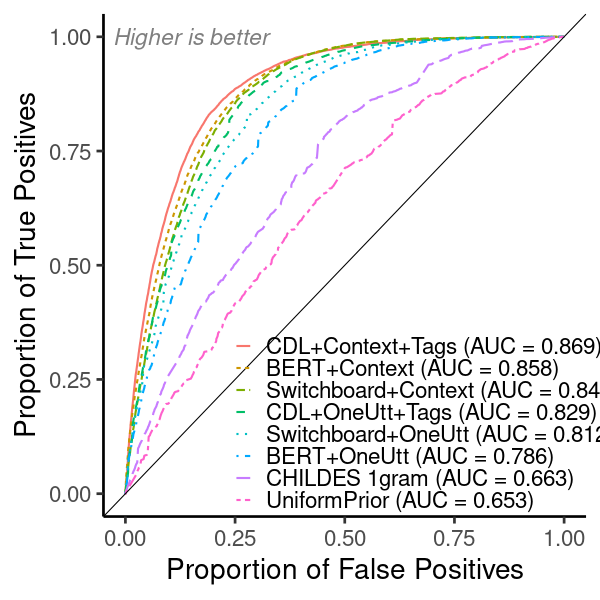

time: 4.37 s (started: 2022-02-16 07:00:29 -08:00)


In [33]:
%%R -h 600 -w 600
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_levdist_auc, linetype = model_with_levdist_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
ggsave('../../output/figures/roc_levdist.pdf', height=12, width=12)    
print(p1)

## WFST

In [34]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(scores_across_time_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 1min 12s (started: 2022-02-16 07:00:33 -08:00)


In [35]:
%%R

# get rid of tags in the designation
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
scores_across_time_overview_set$model_shortname = gsub('\\+Tags','', scores_across_time_overview_set$model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

time: 7.06 s (started: 2022-02-16 07:01:46 -08:00)


In [36]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model = merge(names_per_model, scores_per_model)
scores_per_model = scores_per_model[order(scores_per_model$auc_wfst, decreasing=T),]
print(scores_per_model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model$model_shortname_with_wfst_auc))

      model_shortname     model_shortname_with_wfst_auc  auc_wfst
3         CDL+Context         CDL+Context (AUC = 0.915) 0.9147973
1        BERT+Context        BERT+Context (AUC = 0.903) 0.9025264
6 Switchboard+Context Switchboard+Context (AUC = 0.899) 0.8994706
4          CDL+OneUtt          CDL+OneUtt (AUC = 0.893) 0.8926886
7  Switchboard+OneUtt  Switchboard+OneUtt (AUC = 0.875) 0.8752968
2         BERT+OneUtt         BERT+OneUtt (AUC = 0.846) 0.8456843
5       CHILDES 1gram       CHILDES 1gram (AUC = 0.755) 0.7554012
8        UniformPrior        UniformPrior (AUC = 0.628) 0.6275376
time: 3.74 s (started: 2022-02-16 07:01:53 -08:00)


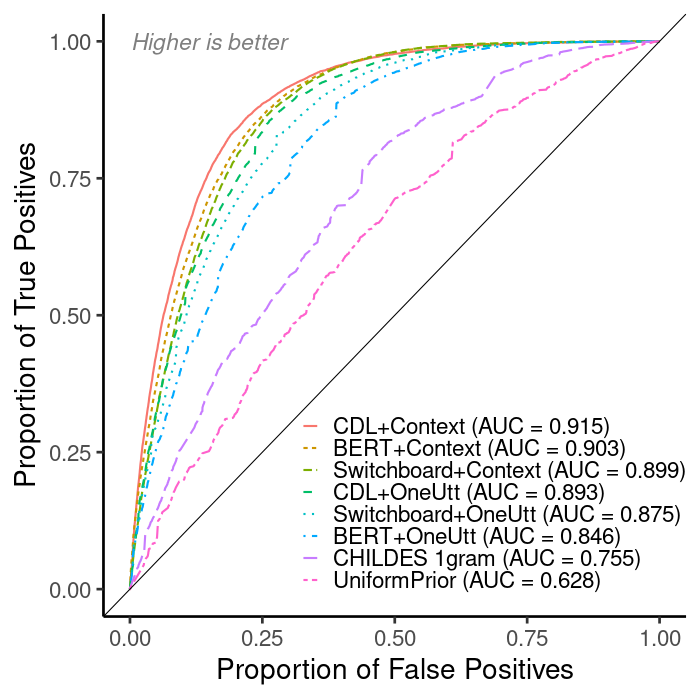

time: 3.91 s (started: 2022-02-16 07:01:57 -08:00)


In [37]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc, linetype = model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_likelihoods.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [38]:
%%R
g <- ggplot_build(p1)
colors_for_8_plots = unique(g$data[[1]]$colour)
reorder = c(1,3,2,4,5,6,7,8)
colors_for_8_plots = colors_for_8_plots[reorder]
print(colors_for_8_plots)

[1] "#F8766D" "#7CAE00" "#CD9600" "#00BE67" "#00BFC4" "#00A9FF" "#C77CFF"
[8] "#FF61CC"
time: 1.72 s (started: 2022-02-16 07:02:01 -08:00)


In [39]:
%%R
models_for_8_plots = scores_per_model$model_shortname[reorder]
print(as.character(models_for_8_plots))
shapes_for_8_plots = c(19, 17,  7, 18, 4, 15, 3, 1)

[1] "CDL+Context"         "Switchboard+Context" "BERT+Context"       
[4] "CDL+OneUtt"          "Switchboard+OneUtt"  "BERT+OneUtt"        
[7] "CHILDES 1gram"       "UniformPrior"       
time: 15.9 ms (started: 2022-02-16 07:02:02 -08:00)


## Visualization of Successes and Failures

In [40]:
%%R
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "Switchboard+OneUtt"       "Switchboard+Context"     
[17] "UniformPrior"             "CHILDES 1gram"           
time: 71.5 ms (started: 2022-02-16 07:02:02 -08:00)


In [41]:
%%R
names(scores_across_time_short)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "set_binarized"        
time: 27.1 ms (started: 2022-02-16 07:02:02 -08:00)


In [42]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "CDL+Context+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

time: 1.3 s (started: 2022-02-16 07:02:02 -08:00)


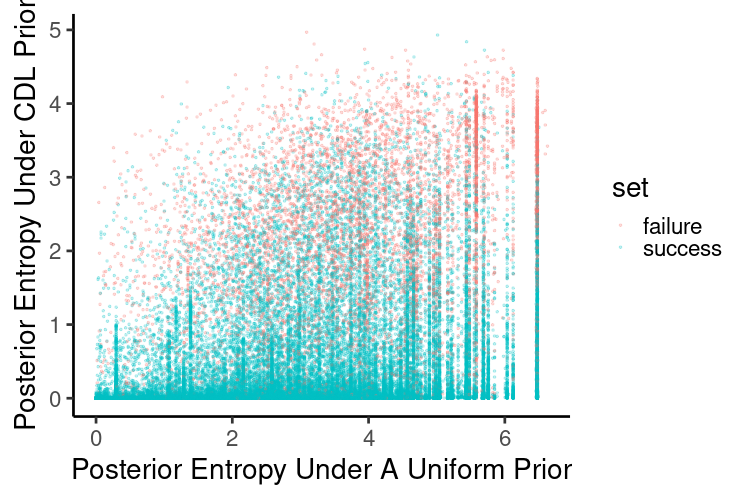

time: 814 ms (started: 2022-02-16 07:02:04 -08:00)


In [43]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

# Analysis 2: Do the models find the same words as adults?

## Priors

In [44]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 28.1 ms (started: 2022-02-16 07:02:05 -08:00)


### Prior Table

#### WFST

In [45]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})


prior_probs = merge(prior_probs, posterior_probs)
    
prior_probs = prior_probs[order(prior_probs$prior_probability),]
subset(prior_probs, model %in% overview_set)

                 model prior_probability posterior_probability
4     CDL+Context+Tags          3.330677             0.6464443
16 Switchboard+Context          4.171558             0.8905783
1         BERT+Context          4.620648             1.0644113
10     CDL+OneUtt+Tags          5.066861             1.0963438
17  Switchboard+OneUtt          6.518799             1.5814190
2          BERT+OneUtt          7.338912             1.8815163
15       CHILDES 1gram          8.786068             2.2773164
18        UniformPrior         12.965243             4.6082285
time: 864 ms (started: 2022-02-16 07:02:05 -08:00)


In [46]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'mean_prior_rank')

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model'))
rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

                 model mean_prior_rank mean_posterior_rank
4     CDL+Context+Tags        50.48621            2.457164
16 Switchboard+Context       116.21612            4.846891
10     CDL+OneUtt+Tags       125.69245            6.965835
1         BERT+Context       140.76924            6.176142
15       CHILDES 1gram       313.72412           14.542632
17  Switchboard+OneUtt       375.80207           14.666705
2          BERT+OneUtt       495.14341           17.875139
18        UniformPrior      3998.00000           62.402769
time: 810 ms (started: 2022-02-16 07:02:06 -08:00)


In [47]:
%%R
for_table = subset(merge(prior_probs, rankings, all.x=T), model %in% overview_set)
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
for_table = for_table[,c('model','prior_probability','mean_prior_rank','posterior_probability','mean_posterior_rank')]
for_table =  for_table[order(for_table$prior_probability),]
names(for_table) = c('Model', 'Prior Surprisal (bits)', 'Mean Prior Rank', 'Posterior Surprisal (bits)', 'Mean Posterior Rank')
for_table

                 Model Prior Surprisal (bits) Mean Prior Rank
4     CDL+Context+Tags                   3.33           50.49
16 Switchboard+Context                   4.17          116.22
1         BERT+Context                   4.62          140.77
10     CDL+OneUtt+Tags                   5.07          125.69
17  Switchboard+OneUtt                   6.52          375.80
2          BERT+OneUtt                   7.34          495.14
15       CHILDES 1gram                   8.79          313.72
18        UniformPrior                  12.97         3998.00
   Posterior Surprisal (bits) Mean Posterior Rank
4                        0.65                2.46
16                       0.89                4.85
1                        1.06                6.18
10                       1.10                6.97
17                       1.58               14.67
2                        1.88               17.88
15                       2.28               14.54
18                       4.61             

In [48]:
%%R
write.csv(for_table, '../../output/csv/surprisal_table.csv', row.names=F)

time: 8.5 ms (started: 2022-02-16 07:02:06 -08:00)


#### Levenshtein Distance

In [49]:
%%R
prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})


prior_probs = merge(prior_probs, posterior_probs)
    
prior_probs = prior_probs[order(prior_probs$prior_probability),]
subset(prior_probs, model %in% overview_set)

                 model prior_probability posterior_probability
4     CDL+Context+Tags          3.330677              1.183490
16 Switchboard+Context          4.171558              1.596443
1         BERT+Context          4.620648              1.719009
10     CDL+OneUtt+Tags          5.066861              1.965825
17  Switchboard+OneUtt          6.518799              2.624089
2          BERT+OneUtt          7.338912              2.884170
15       CHILDES 1gram          8.786068              3.841817
18        UniformPrior         12.965243              5.059256
time: 974 ms (started: 2022-02-16 07:02:06 -08:00)


In [50]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'mean_prior_rank')

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model'))
rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

                 model mean_prior_rank mean_posterior_rank
4     CDL+Context+Tags        50.48621             8.15016
16 Switchboard+Context       116.21612            15.21783
10     CDL+OneUtt+Tags       125.69245            25.51499
1         BERT+Context       140.76924            19.10486
15       CHILDES 1gram       313.72412            51.08235
17  Switchboard+OneUtt       375.80207            45.05684
2          BERT+OneUtt       495.14341            48.14005
18        UniformPrior      3998.00000           145.84482
time: 793 ms (started: 2022-02-16 07:02:07 -08:00)


In [51]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type CDL+Context+Tags  CDL+Context CDL+OneUtt+Tags
2          10577            WFST     7.979536e-07 8.217112e-07    6.114331e-05
4          39428            WFST     5.144511e-04 5.362953e-04    2.304789e-03
6          39594            WFST     6.766981e-01 4.591151e-01    2.304789e-03
8          41265            WFST     5.279500e-01 7.640047e-01    2.071336e-01
10         41266            WFST     3.324036e-01 2.300410e-01    7.424235e-03
12         41756            WFST     5.162919e-05 3.996108e-06    1.043957e-03
     CDL+OneUtt BERT+Context  BERT+OneUtt CDL+Older+Context+Tags
2  0.0001452165 3.667986e-06 6.627159e-05           9.981517e-06
4  0.0020841213 2.478556e-04 1.482733e-04           1.055205e-03
6  0.0020841213 1.482334e-02 1.482733e-04           8.000188e-01
8  0.0415429659 7.339125e-01 2.187229e-02           7.277727e-01
10 0.0043940423 3.372585e-01 3.032029e-04           1.879513e-01
12 0.0003051029 6.015644e-06 3.048955e-06           6.055

In [52]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
[1] "CDL+Context+Tags"    "BERT+Context"        "CDL+OneUtt+Tags"    
[4] "BERT+OneUtt"         "Switchboard+Context" "Switchboard+OneUtt" 
[7] "CHILDES 1gram"       "UniformPrior"       
[1] 42836    20
time: 41.5 ms (started: 2022-02-16 07:02:09 -08:00)


In [53]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"
time: 9.67 ms (started: 2022-02-16 07:02:09 -08:00)


### t-test Model Comparison

In [54]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                    CDL+Context+Tags  BERT+Context CDL+OneUtt+Tags
CDL+Context+Tags                  NA  0.000000e+00               0
BERT+Context                       0            NA               0
CDL+OneUtt+Tags                    0  0.000000e+00              NA
BERT+OneUtt                        0  0.000000e+00               0
Switchboard+Context                0 1.030953e-300               0
Switchboard+OneUtt                 0  0.000000e+00               0
CHILDES 1gram                      0  0.000000e+00               0
UniformPrior                       0  0.000000e+00               0
                      BERT+OneUtt Switchboard+Context Switchboard+OneUtt
CDL+Context+Tags     0.000000e+00        0.000000e+00       0.000000e+00
BERT+Context         0.000000e+00       1.030953e-300       0.000000e+00
CDL+OneUtt+Tags      0.000000e+00        0.000000e+00       0.000000e+00
BERT+OneUtt                    NA        0.000000e+00      9.883847e-125
Switchboard+Context  0.000000e+0

### Prior Surprisal Across Ages Plots

In [55]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,7.274773,0.115150
2,1.0,BERT+Context,WFST,7.274773,0.115150
3,1.0,BERT+OneUtt,Levenshtein Distance,11.540592,0.109994
4,1.0,BERT+OneUtt,WFST,11.540592,0.109994
5,1.0,CDL+Context,Levenshtein Distance,4.130148,0.109045
...,...,...,...,...,...
212,3.5,Switchboard+Context,WFST,3.557584,0.082272
213,3.5,Switchboard+OneUtt,Levenshtein Distance,5.087302,0.092367
214,3.5,Switchboard+OneUtt,WFST,5.087302,0.092367
215,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000


time: 3.86 s (started: 2022-02-16 07:02:09 -08:00)


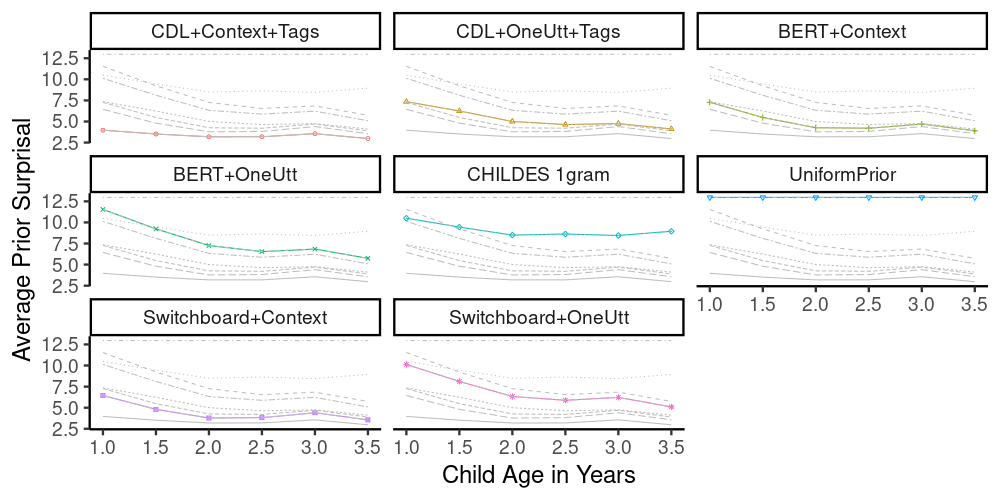

time: 888 ms (started: 2022-02-16 07:02:13 -08:00)


In [56]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none') + scale_shape_manual(values=1:nlevels(overview_mean_surprisal_by_age$model)
    ) + scale_color_discrete()

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

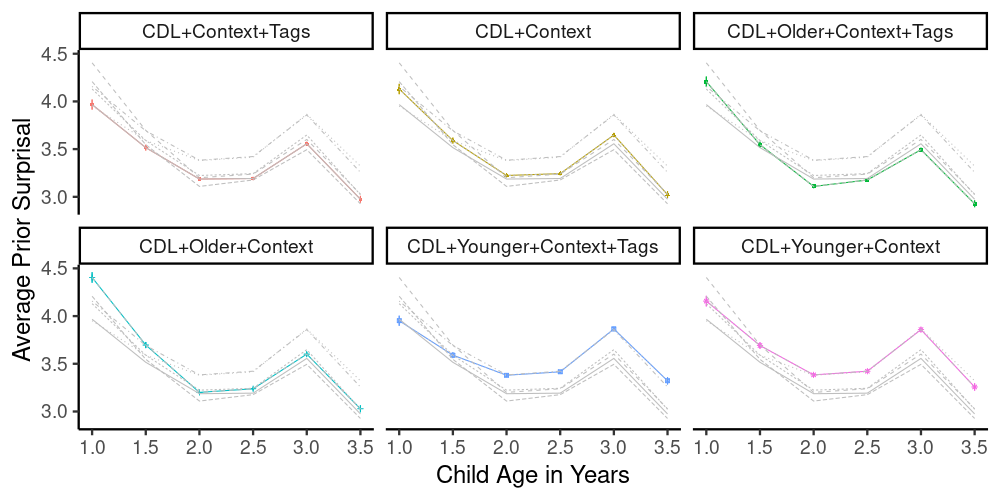

time: 418 ms (started: 2022-02-16 07:02:14 -08:00)


In [57]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [58]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,4.345187,0.114305
2,1.0,BERT+Context,WFST,2.791358,0.089477
3,1.0,BERT+OneUtt,Levenshtein Distance,7.309036,0.149313
4,1.0,BERT+OneUtt,WFST,5.122672,0.124067
5,1.0,CDL+Context,Levenshtein Distance,2.359120,0.089852
...,...,...,...,...,...
212,3.5,Switchboard+Context,WFST,0.411890,0.029452
213,3.5,Switchboard+OneUtt,Levenshtein Distance,1.301500,0.058171
214,3.5,Switchboard+OneUtt,WFST,0.748000,0.039734
215,3.5,UniformPrior,Levenshtein Distance,3.800962,0.072356


time: 3.71 s (started: 2022-02-16 07:02:14 -08:00)


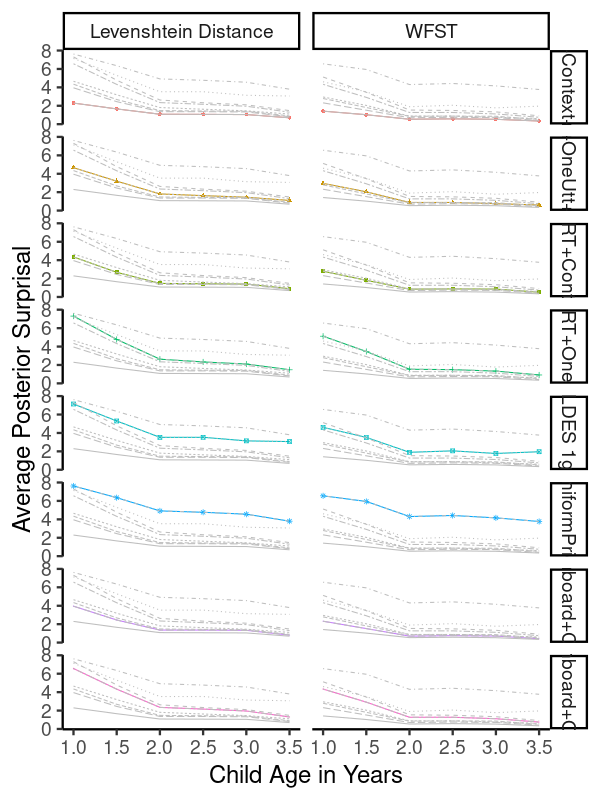

time: 665 ms (started: 2022-02-16 07:02:18 -08:00)


In [59]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


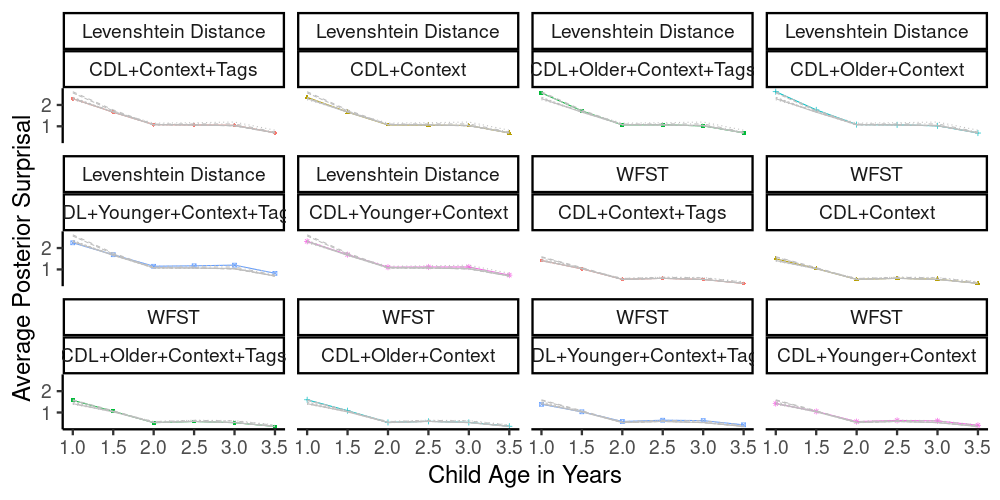

time: 742 ms (started: 2022-02-16 07:02:19 -08:00)


In [60]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [61]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+Context"             "BERT+OneUtt"             
 [3] "CDL+Context"              "CDL+Context+Tags"        
 [5] "CDL+Older+Context"        "CDL+Older+Context+Tags"  
 [7] "CDL+Older+OneUtt"         "CDL+Older+OneUtt+Tags"   
 [9] "CDL+OneUtt"               "CDL+OneUtt+Tags"         
[11] "CDL+Younger+Context"      "CDL+Younger+Context+Tags"
[13] "CDL+Younger+OneUtt"       "CDL+Younger+OneUtt+Tags" 
[15] "CHILDES 1gram"            "Switchboard+Context"     
[17] "Switchboard+OneUtt"       "UniformPrior"            
time: 34.2 ms (started: 2022-02-16 07:02:20 -08:00)


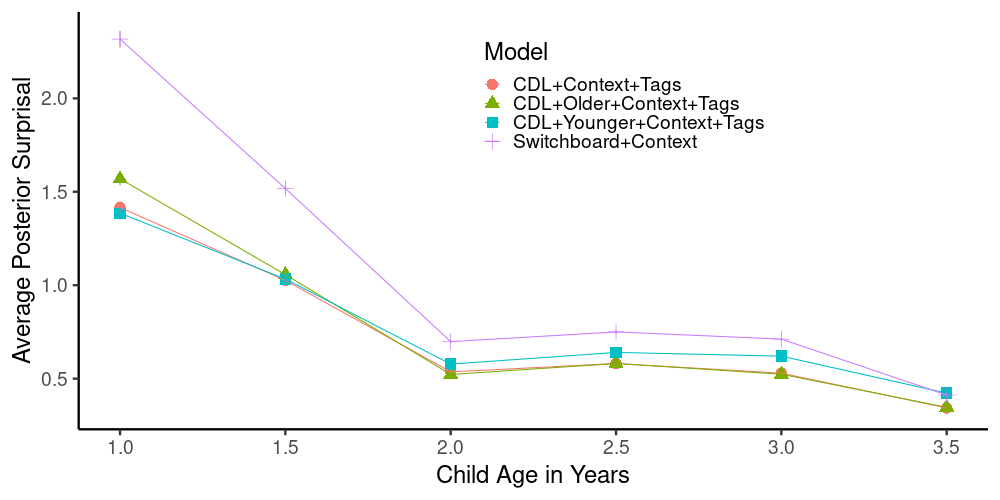

time: 398 ms (started: 2022-02-16 07:02:20 -08:00)


In [62]:
%%R -w 1000 -h 500

selected_models = c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags', 'CDL+Context+Tags','Switchboard+Context')

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    ) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model), size=5) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model"))

ggsave('../../output/figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1

In [63]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    45178
failure     6756
Name: set, dtype: int64

time: 81.4 ms (started: 2022-02-16 07:02:20 -08:00)


### Posterior Probability by Edit Distance Plot

In [64]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 352000     15
time: 234 ms (started: 2022-02-16 07:02:20 -08:00)


In [65]:
%%R
unique(as.character(levdists$model))

[1] "BERT+OneUtt"         "BERT+Context"        "CDL+OneUtt+Tags"    
[4] "CDL+Context+Tags"    "Switchboard+OneUtt"  "Switchboard+Context"
[7] "UniformPrior"        "CHILDES 1gram"      
time: 23.8 ms (started: 2022-02-16 07:02:20 -08:00)


In [66]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

time: 3.85 ms (started: 2022-02-16 07:02:20 -08:00)


In [67]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 352000     15
[1] 352000     16
time: 16.3 ms (started: 2022-02-16 07:02:20 -08:00)


In [68]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

time: 1min 43s (started: 2022-02-16 07:02:20 -08:00)


In [69]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

     bert_token_id edit_distance
1891       1776009             3
1892       1029904             2
1893       1029905             2
1894        506615             1
1895        506616             2
1896        506620             1
1897        506621             0
1898        940389             0
1899        940390             0
1900        855679             3
time: 39 ms (started: 2022-02-16 07:04:03 -08:00)


In [70]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

time: 1min 46s (started: 2022-02-16 07:04:03 -08:00)


In [71]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 3 0 1 2 5 4 6 7 8
time: 69.7 ms (started: 2022-02-16 07:05:50 -08:00)


In [72]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem


time: 7.57 s (started: 2022-02-16 07:05:50 -08:00)


In [73]:
%%R
models_for_8_plots

[1] "CDL+Context"         "Switchboard+Context" "BERT+Context"       
[4] "CDL+OneUtt"          "Switchboard+OneUtt"  "BERT+OneUtt"        
[7] "CHILDES 1gram"       "UniformPrior"       
time: 18.3 ms (started: 2022-02-16 07:05:58 -08:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



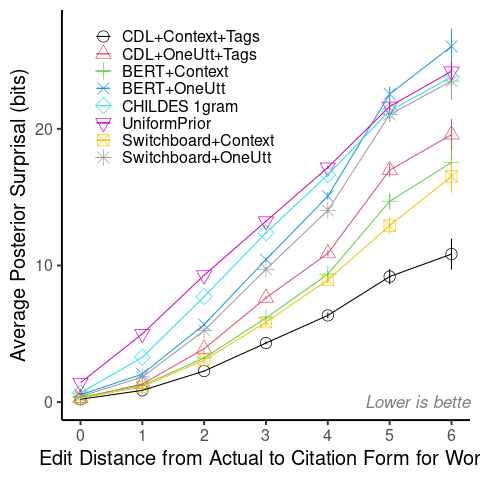

time: 654 ms (started: 2022-02-16 07:05:58 -08:00)


In [74]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type != 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + scale_shape_manual(values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=1:nlevels(surprisal_by_edit_distance_for_plot$model))

ggsave('../../output/figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

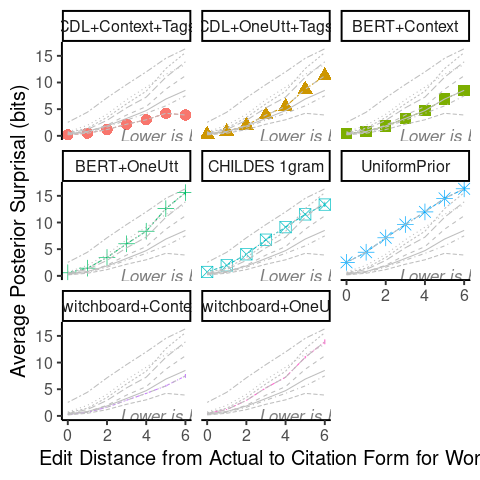

time: 634 ms (started: 2022-02-16 07:05:58 -08:00)


In [75]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance

In [76]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance               model      likelihood_type
1              0        BERT+Context Levenshtein Distance
2              0         BERT+OneUtt Levenshtein Distance
3              0    CDL+Context+Tags Levenshtein Distance
4              0     CDL+OneUtt+Tags Levenshtein Distance
5              0       CHILDES 1gram Levenshtein Distance
6              0 Switchboard+Context Levenshtein Distance
7              0  Switchboard+OneUtt Levenshtein Distance
8              0        UniformPrior Levenshtein Distance
9              1        BERT+Context Levenshtein Distance
10             1         BERT+OneUtt Levenshtein Distance
   mean_posterior_surprisal mean_posterior_surprisal_sem      high       low
1                 0.3562092                  0.008921247 0.3651305 0.3472880
2                 0.5353647                  0.010170019 0.5455347 0.5251947
3                 0.2120225                  0.005978211 0.2180008 0.2060443
4                 0.2940632                  0.0064534

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



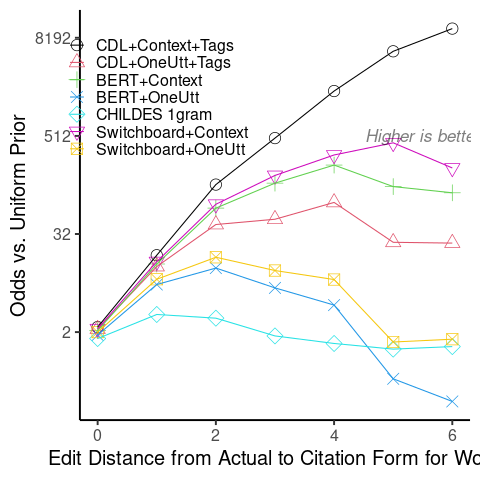

time: 457 ms (started: 2022-02-16 07:05:59 -08:00)


In [77]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2'
) + scale_shape_manual(values = 1:8) + scale_color_manual(values = 1:8)
ggsave('../../output/figures/multiplier_by_edit_dstance_log_scale_all.pdf', height=6, width=8)    
print(p2)

#### WFST

In [78]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_8_plots)



time: 4.94 ms (started: 2022-02-16 07:05:59 -08:00)


In [79]:
%%R
as.character(surprisal_by_edit_distance_for_plot$model_shortname)

 [1] "BERT+Context"        "BERT+OneUtt"         "CDL+Context"        
 [4] "CDL+OneUtt"          "CHILDES 1gram"       "Switchboard+Context"
 [7] "Switchboard+OneUtt"  "UniformPrior"        "BERT+Context"       
[10] "BERT+OneUtt"         "CDL+Context"         "CDL+OneUtt"         
[13] "CHILDES 1gram"       "Switchboard+Context" "Switchboard+OneUtt" 
[16] "UniformPrior"        "BERT+Context"        "BERT+OneUtt"        
[19] "CDL+Context"         "CDL+OneUtt"          "CHILDES 1gram"      
[22] "Switchboard+Context" "Switchboard+OneUtt"  "UniformPrior"       
[25] "BERT+Context"        "BERT+OneUtt"         "CDL+Context"        
[28] "CDL+OneUtt"          "CHILDES 1gram"       "Switchboard+Context"
[31] "Switchboard+OneUtt"  "UniformPrior"        "BERT+Context"       
[34] "BERT+OneUtt"         "CDL+Context"         "CDL+OneUtt"         
[37] "CHILDES 1gram"       "Switchboard+Context" "Switchboard+OneUtt" 
[40] "UniformPrior"        "BERT+Context"        "BERT+OneUtt"        
[43] "

In [80]:
%%R
colors_for_8_plots

[1] "#F8766D" "#7CAE00" "#CD9600" "#00BE67" "#00BFC4" "#00A9FF" "#C77CFF"
[8] "#FF61CC"
time: 11.8 ms (started: 2022-02-16 07:06:00 -08:00)


R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.



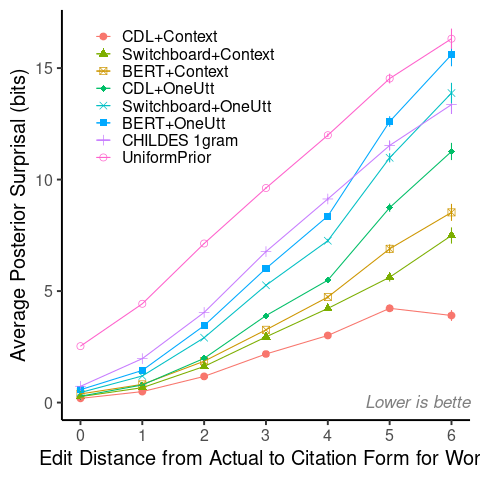

time: 550 ms (started: 2022-02-16 07:06:00 -08:00)


In [81]:
%%R

surprisal_by_edit_distance_for_plot$model = factor(surprisal_by_edit_distance_for_plot,
    levels = models_for_8_plots)


p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model_shortname, shape=model_shortname), size=3) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model_shortname), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model_shortname, 
shape=model_shortname)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
    ) + scale_color_manual(values=colors_for_8_plots) + scale_shape_manual(values = shapes_for_8_plots)

ggsave('../../output/figures/surpsisal_by_edit_distance_likelihoods.pdf', height=6, width=8)    
print(p1)

### Proportion Agreeing with Annotator

In [82]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x < 5)})
proportion_retrieved

                      model      likelihood_type prior_rank
1          CDL+Context+Tags Levenshtein Distance  0.7608938
2               CDL+Context Levenshtein Distance  0.7584161
3           CDL+OneUtt+Tags Levenshtein Distance  0.6000045
4                CDL+OneUtt Levenshtein Distance  0.5986180
5              BERT+Context Levenshtein Distance  0.6526493
6               BERT+OneUtt Levenshtein Distance  0.4362740
7    CDL+Older+Context+Tags Levenshtein Distance  0.7625759
8         CDL+Older+Context Levenshtein Distance  0.7551656
9          CDL+Older+OneUtt Levenshtein Distance  0.5996863
10    CDL+Older+OneUtt+Tags Levenshtein Distance  0.6012547
11 CDL+Younger+Context+Tags Levenshtein Distance  0.7443002
12      CDL+Younger+Context Levenshtein Distance  0.7473007
13  CDL+Younger+OneUtt+Tags Levenshtein Distance  0.5729093
14       CDL+Younger+OneUtt Levenshtein Distance  0.5498602
15            CHILDES 1gram Levenshtein Distance  0.1587753
16             UniformPrior Levenshtein 

In [83]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x == 0)})
proportion_retrieved

                      model      likelihood_type posterior_rank
1          CDL+Context+Tags Levenshtein Distance      0.8208351
2               CDL+Context Levenshtein Distance      0.8228809
3           CDL+OneUtt+Tags Levenshtein Distance      0.7308890
4                CDL+OneUtt Levenshtein Distance      0.7261837
5              BERT+Context Levenshtein Distance      0.7601209
6               BERT+OneUtt Levenshtein Distance      0.6576955
7    CDL+Older+Context+Tags Levenshtein Distance      0.8198350
8         CDL+Older+Context Levenshtein Distance      0.8198577
9          CDL+Older+OneUtt Levenshtein Distance      0.7304571
10    CDL+Older+OneUtt+Tags Levenshtein Distance      0.7309572
11 CDL+Younger+Context+Tags Levenshtein Distance      0.8081740
12      CDL+Younger+Context Levenshtein Distance      0.8156752
13  CDL+Younger+OneUtt+Tags Levenshtein Distance      0.7054077
14       CDL+Younger+OneUtt Levenshtein Distance      0.7119314
15            CHILDES 1gram Levenshtein 

### Proportion Agreeing with Annotator Per Age

In [84]:
%%R
names(successes_across_time)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
time: 20.4 ms (started: 2022-02-16 07:06:02 -08:00)


In [85]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

time: 1.91 s (started: 2022-02-16 07:06:02 -08:00)


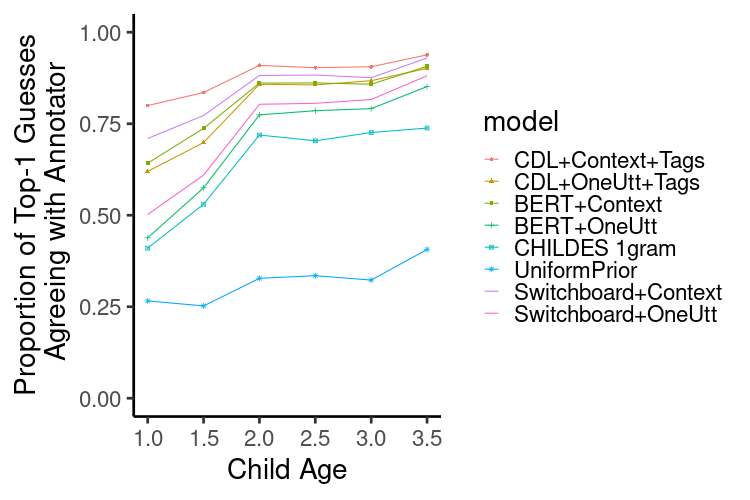

time: 240 ms (started: 2022-02-16 07:06:04 -08:00)


In [86]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model)
) + geom_point(aes(x=age, y=posterior_rank, color=model, shape=model)) + coord_cartesian(ylim=c(0,1)) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank())




# Discussion: Child-Specific Analyses

In [87]:
from src.utils import load_splits
all_tokens_phono = load_splits.load_phono()
all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

time: 1min 10s (started: 2022-02-16 07:06:04 -08:00)


In [88]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

time: 1min 9s (started: 2022-02-16 07:07:14 -08:00)


In [89]:
%%R
names(successes_across_time_with_child_label)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "target_child_name"    
time: 30.5 ms (started: 2022-02-16 07:08:23 -08:00)


In [90]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)
subset(posterior_entropy_by_child, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name posterior_entropy
19  CDL+Context+Tags            WFST              Alex         0.4850162
55  CDL+Context+Tags            WFST             Ethan         0.5900796
91  CDL+Context+Tags            WFST              Lily         0.2838924
127 CDL+Context+Tags            WFST             Naima         0.3600090
163 CDL+Context+Tags            WFST            Violet         0.3905320
199 CDL+Context+Tags            WFST           William         0.4711304
time: 1.87 s (started: 2022-02-16 07:08:23 -08:00)


In [91]:
%%R
proportion_retrieved = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name prior_probability
19  CDL+Context+Tags            WFST              Alex          4.016616
55  CDL+Context+Tags            WFST             Ethan          3.340438
91  CDL+Context+Tags            WFST              Lily          3.009920
127 CDL+Context+Tags            WFST             Naima          3.197227
163 CDL+Context+Tags            WFST            Violet          3.203181
199 CDL+Context+Tags            WFST           William          3.449705
time: 1.07 s (started: 2022-02-16 07:08:25 -08:00)


In [92]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')


               model likelihood_type target_child_name proportion_top_1
19  CDL+Context+Tags            WFST              Alex        0.8714394
55  CDL+Context+Tags            WFST             Ethan        0.8211613
91  CDL+Context+Tags            WFST              Lily        0.9293833
127 CDL+Context+Tags            WFST             Naima        0.9006317
163 CDL+Context+Tags            WFST            Violet        0.8918855
199 CDL+Context+Tags            WFST           William        0.8734289
time: 1.25 s (started: 2022-02-16 07:08:26 -08:00)


In [93]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')



               model likelihood_type target_child_name proportion_top_1
19  CDL+Context+Tags            WFST              Alex        0.4766826
55  CDL+Context+Tags            WFST             Ethan        0.5801290
91  CDL+Context+Tags            WFST              Lily        0.5669935
127 CDL+Context+Tags            WFST             Naima        0.5809038
163 CDL+Context+Tags            WFST            Violet        0.5524012
199 CDL+Context+Tags            WFST           William        0.5423969
time: 915 ms (started: 2022-02-16 07:08:27 -08:00)
